<a href="https://colab.research.google.com/github/jmalonso55/MVP_Jorge_Alonso_Machine_Learning/blob/main/Processamento_de_linguagem_natural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1 - Definição do problema:**

Este script aborda o uso de redes neurais para um problema de processamento de linguagem natural e consiste em parte das análises realizadas para o MVP da Sprint II: Machine Learning & Analytics do curso de Especialização em Ciência de Dados e Analytics.

A base de dados utilizada foi extraída de repositório no Kaggle (https://www.kaggle.com/datasets/sampaiovitor/avaliaes-em-portugus-amazon-e-mercado-livre) e contém comentários extraídos de review de produtos comprados no Brasil pelo site da Amazon. De acordo com a descrição dos dados disponibilizada no Kaggle, a pesquisa foi feita a partir de um input, na coluna "busca", com o título do produto, o link, e a avaliação tendo a finalidade de atender a um projeto para processamento de linguagem natural em português.

Conhecer os comentários de compradores a respeito dos produtos comercializados em um site, pode ser de extrema importância para empresas do varejo selecionarem o que devem comercializar. Além de permitir entender o que as pessoas acham importante em relação à diferentes produtos, quais qualidades eles devem ter para serem considerados bons ou ruins. Por fim, para uma empresa que produz (por exemplo) celulares, os comentários feitos em sites de terceiros que revendem o seu produto podem ser uma fonte de informações para entender melhor a relação entre seus os usuários de seus produtos.

Este seria um problema de aprendizado supervisionado da categoria classificação. Algumas hipóteses seriam:
1) Os principais produtos vendidos e revisados são eletrônicos;
2) Algumas categorias de produtos estão mais ligadas com satisfação ou insastifação de consumidores;
3) As principais palavras utilizadas na revisão mudam de produto para produto e seriam diferentes entre eletrônicos e outra categoria;
4) Seria possível identificar algumas qualidades que os consumidores valorizam nos produtos, assim como aspectos que eles consideram negativos.

Quanto às restrições, o foco da análise serão os comentários feitos por compradores. No entanto outras informações poderiam ser extraídas, como as principais marcas de diferentes produtos que foram compradas. Infelizmente, os comentários não foram relacionados à notas ou classificados como positivos e negativos, limitando as possibilidade de análise.

Os códigos foram elaborados com o auxílio do material disponibilizado no curso além de consultas aos notebooks contidos nos seguintes links:

1 - https://www.kaggle.com/code/jeffd23/visualizing-word-vectors-with-t-sne

2 - https://www.kaggle.com/code/yaowenling/amazon-cell-phone-review-nlp

3 - https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial

O dataset contém 9.815 observações (instâncias) e 4 atributos, sendo eles o termo de busca (Search Query), o título do produto (Product Title), o link para o anúncio (Link) e a revisão sobre a compra (Review).


# **2 - Carregamento de bibliotecas e dos dados**

In [113]:
# Instalando bibliotecas
!pip install -U spacy
!python3 -m spacy download pt_core_news_sm

2023-07-23 18:11:44.655231: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 48.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [114]:
# Carregando as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import multiprocessing
import spacy
import re
import string
import time
import logging
from spacy.lang.pt.stop_words import STOP_WORDS
from spacy.lang.pt.examples import sentences
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import defaultdict
from wordcloud import WordCloud
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [115]:
# Importa do repositório no GitHub os dados do IFN no ES filtrados na Sprint 1
url_dados = 'https://raw.githubusercontent.com/jmalonso55/MVP_Jorge_Alonso_Machine_Learning/main/am_scrape_final.csv'

# Carrega o dataset por meio da url
review = pd.read_csv(url_dados, sep=",", decimal=".")


In [116]:
# Inspeciona as primeiras linhas do dataset
review.head(5)

,Search Query,Product Title,Link,Review
0,smartphone,Smartphone Xiaomi Note 12 4G 128GB 6GB Ram (VE...,https://www.amazon.com.br/dp/B0BZ7RJDHD,Com a necessidade de comprar um celular custo ...
1,smartphone,Smartphone Xiaomi Note 12 4G 128GB 6GB Ram (VE...,https://www.amazon.com.br/dp/B0BZ7RJDHD,Minha experiência de 10 dias de uso com o Xiao...
2,smartphone,Smartphone Xiaomi Note 12 4G 128GB 6GB Ram (VE...,https://www.amazon.com.br/dp/B0BZ7RJDHD,"Smartphone de qualidade como já esperava, boas..."
3,smartphone,Smartphone Xiaomi Note 12 4G 128GB 6GB Ram (VE...,https://www.amazon.com.br/dp/B0BZ7RJDHD,atendeu mto minhas expectativas. Antes eu usa...
4,smartphone,Smartphone Xiaomi Note 12 4G 128GB 6GB Ram (VE...,https://www.amazon.com.br/dp/B0BZ7RJDHD,"Gostei muito do celular, tem resposta rápida e..."


In [117]:
# Verificando as dimensões dos dados
print(review.shape)

(9815, 4)


Os dados parecem ter sido corretamente carregados e é possível confirmar a existência de 9.815 instâncias e 4 atributos.

# **3 - Visualização de dados preliminares e pré-processamento**

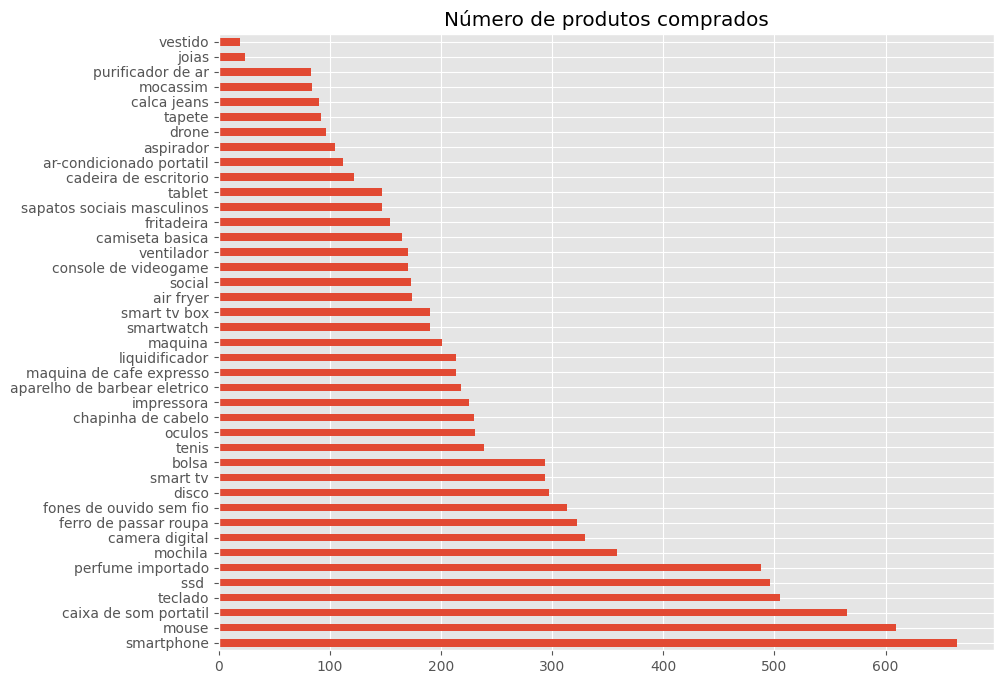

In [118]:
# Plotando os itens mais comprados
plt.style.use("ggplot")

# Gerando o gráfico
ax = review["Search Query"].value_counts().plot(kind="barh",
                                               figsize=(10, 8),
                                               title="Número de produtos comprados")
plt.show()

Verifica-se que smartfones são os produtos mais comercializados. Além disso, os cinco produtos mais vendidos são todos eletrônicos. Em sexto observa-se perfumes importados, como o "não-eletrônico" mais bem posicionado.

In [119]:
# Carregar o modelo de idioma em português do spaCy
nlp = spacy.load("pt_core_news_sm", disable=['ner', 'parser'])  # Desabilitando Named Entity Recognition para ganho de velocidade

# Definir as palavras de parada (stop words) para o idioma português
stop = set(STOP_WORDS)

# Definir conjunto de pontuações
punc = set(string.punctuation)

def clean_text(text):
    # Converte o texto para letras minúsculas
    text = text.lower()

    # Processa o texto com o spaCy (lematização e tokenização)
    doc = nlp(text)

    # Remove a pontuação e as stopwords, e faz a lematização
    wordList = [token.lemma_ for token in doc if token.text not in punc and token.text.lower() not in stop]

    return " ".join(wordList)

In [120]:
# Testando a função de pré-processamento
clean_text("Eu adorei esse celular!!!!")

'adorar celular'

Foi criada uma função clean_text para realizar algumas etapas do pré-processamento dos dados, incluindo a conversão para letras minúsculas, remoção de pontuação, stopwords e lematização das palavras.

Por fim, a função foi testada e demonstrou ter funcionado corretamente no exemplo.

In [121]:
# Aplicando o pré-processamento aos dados
review['Review'] = review['Review'].astype('str')
review['clean_text'] = review['Review'].apply(clean_text)

In [122]:
# Inicializa o dicionário para contar a frequência das palavras
word_freq = defaultdict(int)

# Itera sobre cada sentença do conjunto de dados
for sent in review['clean_text']:
    # Divide a sentença em palavras individuais
    words = sent.split()
    # Itera sobre cada palavra na sentença e conte sua frequência
    for word in words:
        word_freq[word] += 1

# Verifica o número de palavras únicas no conjunto de dados
num_unique_words = len(word_freq)
print("Número de palavras únicas:", num_unique_words)

Número de palavras únicas: 20405


In [123]:
# Apresenta as principais palavras presentes no texto
print(sorted(word_freq, key=word_freq.get, reverse=True)[:10])

['the', 'produto', 'to', 'and', 'i', 'it', 'bom', 'qualidade', 'is', 'of']


Observa-se que foram filtradas 20.405 palavras únicas do texto. No entanto, verificando as dez principais palavras do texto, percebe-se que várias delas são stopwords da língua inglesa. Portanto, os dados necessitam de mais operações para pré-processamento.

In [124]:
# Faz o download das stopwords em inglês
nltk.download('stopwords')
stop_words_english = set(stopwords.words('english'))

# Função para remover as stopwords em inglês
def remove_stopwords(text):
    return " ".join(word for word in text.split() if word.lower() not in stop_words_english)

# Aplica a função ao conjunto de dados em português
review['clean_text_without_stopwords'] = review['clean_text'].apply(remove_stopwords)

# Contar a frequência das palavras no conjunto de dados sem stopwords em inglês
word_freq = defaultdict(int)
for text in review['clean_text_without_stopwords']:
    for word in text.split():
        word_freq[word] += 1


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


A existência de muitas stopwords em inglês no texto indica que existem algumas revisões feitas em língua inglesa na base de dados. Optou-se por remover apenas stopwords em inglês e não todas as palavras para evitar a perda de informações referentes a termos utilizados também em português, o que é comum na categoria dos eletrônicos e nomes de marcas (por exemplo: mouse, camera, Amazon).


In [125]:
# Verificando o texto
review['clean_text_without_stopwords'].head().values

array(['necessidade comprar celular custo benefício começar pesquisar modelo vender mercado deparei líder samsung motorola ... apple custo-benefício brasil.eu smartphone de esse marca supracitar xiaomi.por conseguinte analisar vídeo ter varia opção caber citar entregar qualidade característica conjunto completo deixar desejar.partindo premissa saí celular seguinte estado:-marca samsung-modelo Gran prime-ano lançamento 2015-armazenamento 8 gb memória interna.considerar mercado atual smartphone catastrófico.associo escolha Marca condizr objetivo:- precisar tela tela bom mercado celular entrada).- ter necessidade bateria jus marca contar carregamento ultra rápido oferecem).- buscar câmera tirar bom foto mercado nenhum celular categoria mesmo função top linha).- visar celular travar 6 gb memória r rodar jogo pesado play story call duty Genshin Impact chegueir jogar legend Neverland rodar gráfico leg proposta faixa preço aparelho pra jogar jogo tranquilamente modo light).portanto aquisição 

In [126]:
# Inicialize o dicionário para contar a frequência das palavras
word_freq = defaultdict(int)

# Itere sobre cada sentença do conjunto de dados
for sent in review['clean_text_without_stopwords']:
    # Divida a sentença em palavras individuais
    words = sent.split()
    # Itere sobre cada palavra na sentença e conte sua frequência
    for word in words:
        word_freq[word] += 1

# Verifique o número de palavras únicas no conjunto de dados
num_unique_words = len(word_freq)
print("Número de palavras únicas:", num_unique_words)


Número de palavras únicas: 20219


In [127]:
# Apresenta as principais palavras presentes no texto
print(sorted(word_freq, key=word_freq.get, reverse=True)[:10])

['produto', 'bom', 'qualidade', 'gostar', 'chegar', 'pra', 'excelente', 'rápido', 'comprar', 'dia']


Observa-se que houve uma redução na ordem de 1% das palavras filtradas anteriormente. Observando uma amostra do texto, é possíovel ver que ainda existem palavras em inglês entre os dados, em sua maioria ligadas a nomes de produtos. Observa-se que algumas palavras foram unidas de maneira indevida, representando um dos desafios de processar esse tipo de dados. Como não foi encontrada uma forma eficiente de resolver esses problemas, optou-se por proceder às análises.

Por fim, a lista das 10 palavras mais frequentes agora apresenta apenas termos em português e as stopwords em inglês foram removidas.

# **4 - Avaliando as principais palavras utilizadas:**

In [128]:
# Criando subsets para alguns tipos de produto
smartphone = review[review["Search Query"]=="smartphone"]
mouse = review[review["Search Query"]=="mouse"]
caixa = review[review["Search Query"]=="caixa de som portatil"]
perfume = review[review["Search Query"]=="perfume importado"]

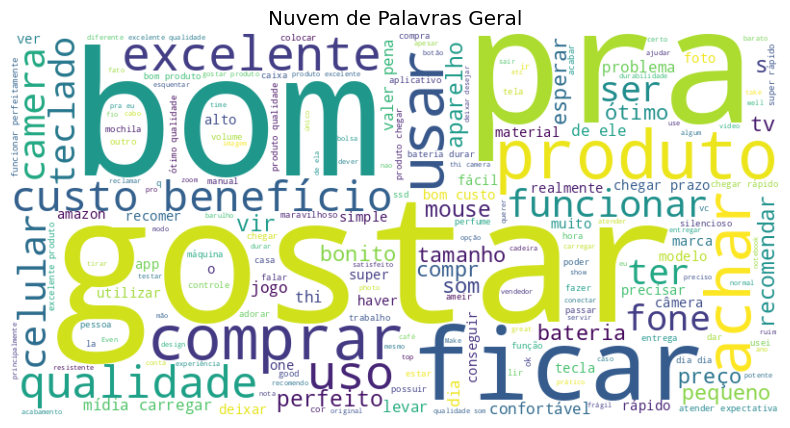

In [129]:
# Termos no geral

# Concatena todas as strings em uma
all_text = ' '.join(review['clean_text_without_stopwords'])

# Cria a nuvem de palavras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plota a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nuvem de Palavras Geral")
plt.show()


Observa-se que palavras relacionadas a sentimentos positivos (gostar, bom, excelente) estão entre as mais utilizadas pelos compradores, demonstrando que na maioria das vezes as pessoas ficam felizes com suas aquisições. No entanto, as informações de maior valor para as empresas seriam as críticas que clientes possam ter em relação a seus produtos, o que demonstra uma limitação da base de dados avaliada, que não classifica ou rankeia os comentários.

Outros termos em destaques são relacionados ao principais produtos comercializados (celular, camera, bateria, mouse, teclado).

Algumas palavras como porém e problema podem ser ligadas a comentários negativos e carecem de mais análises para melhor entendimento.

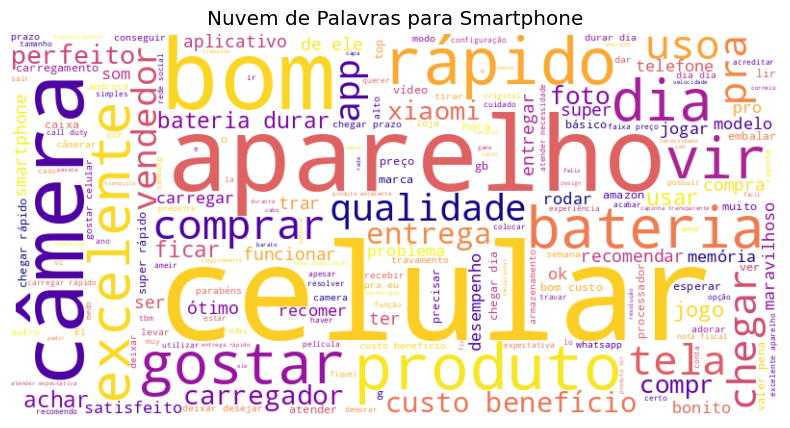

In [130]:
# Para smartfones

# Concatena todas as strings em uma para o subset de smartfone
smartphone_text = ' '.join(smartphone['clean_text_without_stopwords'])

# Cria a nuvem de palavras para o subset de smartphone
smartphone_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='plasma').generate(smartphone_text)

# Plota a nuvem de palavras para o subset de smartphone
plt.figure(figsize=(10, 5))
plt.imshow(smartphone_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nuvem de Palavras para Smartphone")
plt.show()

Fazendo o filtro das palavras mais utilizadas para smartfones, conseguimos observar que boa parte dos comentários denotam satisfação com o produto (bom, excelente, gostar).

Conseguimos identificar também algumas características que são importantes para consumidores desses produtos, como bateria, câmera, carregador, desempenho, memória e tela. E outras características inerentes ao site e o terceiro que vez a venda como entrega, vendedor, bem embalado, foto.

Entre as marcas, Xiaomi parece ter sido o destaque.

Outros termos que valem uma melhor apuração são rápido, recomendo, pouco, preço, problema e qualidade.

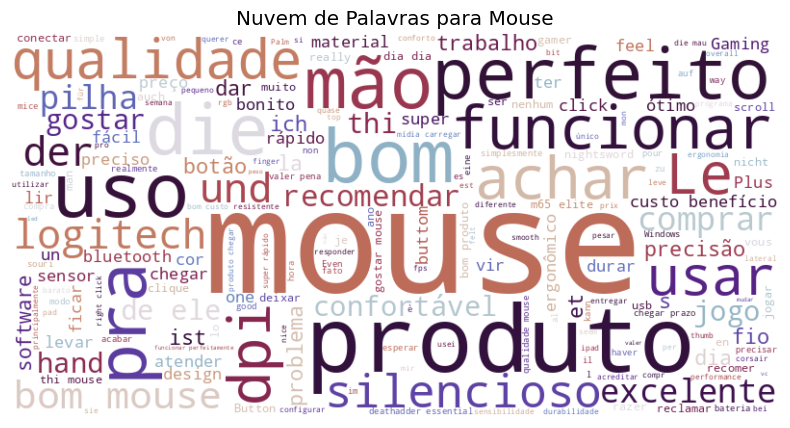

In [131]:
# Para mouse

# Concatena todas as strings em uma para o subset de mouse
mouse_text = ' '.join(mouse['clean_text_without_stopwords'])

# Cria a nuvem de palavras para o subset de mouse
mouse_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='twilight').generate(mouse_text)

# Plota a nuvem de palavras para o subset de mouse
plt.figure(figsize=(10, 5))
plt.imshow(mouse_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nuvem de Palavras para Mouse")
plt.show()

Para mouses observamos a mesma tendência do geral e smartfones, os consumidores que comentam parecem em grande parte estarem felizes com suas compras.

Em relação ao produto, termos de destaque foram sensor, silencioso, confortável, jogo, pilha, confortável, mão e precisão.

Para mouse a entrega e o vendedor parecem ter menos importância para consumidores. Talvez por se tratar de um item mais barato e menos valorizado pelas pessoas no dia a dia.

Quanto a marcas, destaque para a Logitech.

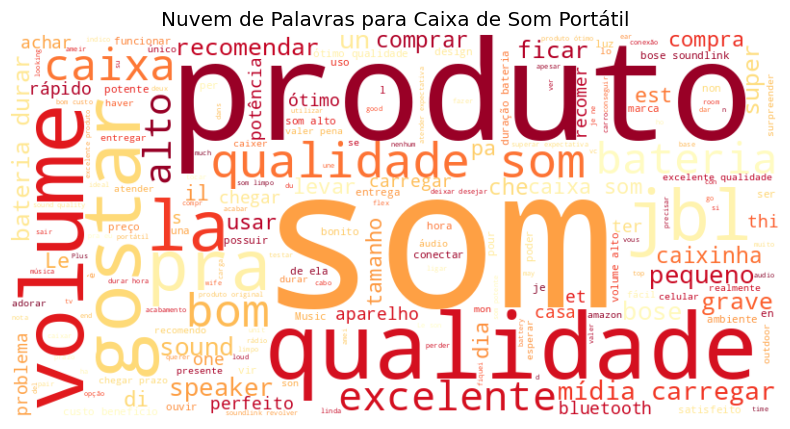

In [132]:
# Para caixa de som portátil

# Concatena todas as strings em uma para o subset de caixa de som portátil
caixa_text = ' '.join(caixa['clean_text_without_stopwords'])

# Cria a nuvem de palavras para o subset de caixa de som portátil
caixa_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='YlOrRd').generate(caixa_text)

# Plota a nuvem de palavras para o subset de caixa de som portátil
plt.figure(figsize=(10, 5))
plt.imshow(caixa_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nuvem de Palavras para Caixa de Som Portátil")
plt.show()

Como esperado, as nuvens entre itens eletrônicos apresentam muitas similaridades. A análise para caixas de som é de certa maneira parecida com a de mouse.

Aqui as características mais observadas por consumidores foram volume, mídia, grave, bateria, potência, bluetooth e tamanho.

Quanto a marcas, há considerável destaque para JBL.

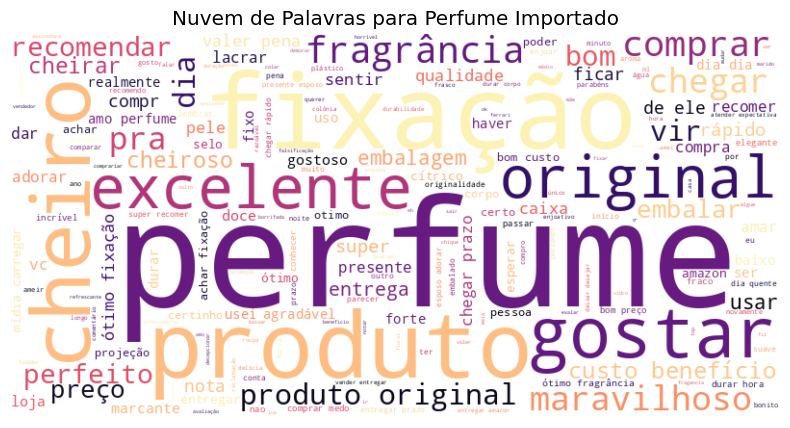

In [133]:
# Para perfume importado

# Concatena todas as strings em uma para o subset de perfume importado
perfume_text = ' '.join(perfume['clean_text_without_stopwords'])

# Cria a nuvem de palavras para o subset de perfume importado
perfume_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate(perfume_text)

# Plota a nuvem de palavras para o subset de perfume importado
plt.figure(figsize=(10, 5))
plt.imshow(perfume_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nuvem de Palavras para Perfume Importado")
plt.show()

Assim como para os eletrônicos, os compradores de perfume parecem satisfeitos com a compra.

As características de destaque são bem diferentes, a fixação é maior preocupação, assim como a fragrância, se o produto é original, custo benefício e a embalagem.

Para esse item a entrega é um ponto importante, o prazo e se chega.

# **5 - Treinando um modelo de rede neural word to vector e analisando os resultados**

In [134]:
# Transformando palavras em vetores e montando o algoritmo
cores = multiprocessing.cpu_count()
nltk.download('punkt')

# Tokenizar as frases e criar uma lista de listas de palavras
sentences = [word_tokenize(text) for text in review['clean_text_without_stopwords']]

# Montando o algoritmo para o modelo Word2Vec
w2v_model = Word2Vec(sentences,
                     min_count=3,
                     window=5,
                     vector_size=300,
                     sample=1e-3,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=cores-1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [135]:
# Treinando o modelo
w2v_model.train(review['clean_text_without_stopwords'], total_examples=w2v_model.corpus_count, epochs=20, report_delay=1)

(19873120, 24374200)

In [136]:
# Procurando palavras similares a bom
w2v_model.wv.most_similar(positive=["bom"])

[('excelente', 0.9579759836196899),
 ('qualidade', 0.9505004286766052),
 ('marca', 0.9451535940170288),
 ('acabamento', 0.9363192915916443),
 ('faixa', 0.9362330436706543),
 ('silencioso', 0.9331369996070862),
 ('comparar', 0.9317388534545898),
 ('caro', 0.9295199513435364),
 ('otimo', 0.9286831617355347),
 ('grave', 0.927838146686554)]

O modelo foi gerado e treinado com sucesso, como teste podemos ver as associações da palavra "bom" com outras. Verifica-se que ela está associada a outros termos positivos, além de marca e acabamento.

Chama a atenção as similaridades com comparar e caro.

In [137]:
# Procurando palavras similares a qualidade
w2v_model.wv.most_similar(positive=["qualidade"])

[('excelente', 0.9781808257102966),
 ('material', 0.976635754108429),
 ('imagem', 0.9699504375457764),
 ('acabamento', 0.9698269367218018),
 ('bonito', 0.9692810773849487),
 ('ótimo', 0.966106653213501),
 ('silencioso', 0.9651381373405457),
 ('potente', 0.9566618204116821),
 ('surpreender', 0.9547715783119202),
 ('maravilhoso', 0.952136218547821)]

Um termo que apresentou resultado interessante foi qualidade. Percebe-se que o consumidor em geral menciona qualidade relacionada a aparência, ou seja, acabamento, imagem, material, bonito.

Qualidade também está relacionada aos termos potente e silencioso.

In [138]:
# Procurando palavras similares a problema
w2v_model.wv.most_similar(positive=["problema"])

[('dar', 0.9588499665260315),
 ('outro', 0.9432289004325867),
 ('ano', 0.9427077770233154),
 ('nenhum', 0.9244862198829651),
 ('compr', 0.917388916015625),
 ('ser', 0.9168494343757629),
 ('apresentar', 0.9147928357124329),
 ('deixar', 0.9133581519126892),
 ('precisar', 0.9129465818405151),
 ('único', 0.9114630818367004)]

A palavra problema tem similaridade com nenhum, ou seja, nem sempre está relacionada com um aspecto negativo da compra. As relações com outro sugerem que quando algo dá problema, existe mais de um. Por outro lado, temos a associação com único.

Outras palavras foram avaliadas como entrega, defeito, rápido, recomendo e preço. Mas as associações que elas apresentaram foram pouco explicativas como ilustrado acima com a palavra problema.

A visualização dos gráficos abaixo demonstra algumas ideias de palavras a serem exploradas.

# 5.1 - Plotando um agrupamento de palavras de acordo com a similaridade entre elas

In [139]:
# Definindo a função para plotar o t-SNE
def tsne_plot(model):
    labels = []
    tokens = []

    for word in model.wv.index_to_key:
        tokens.append(model.wv[word])
        labels.append(word)

    tokens = np.array(tokens)
    tsne_model = TSNE(n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

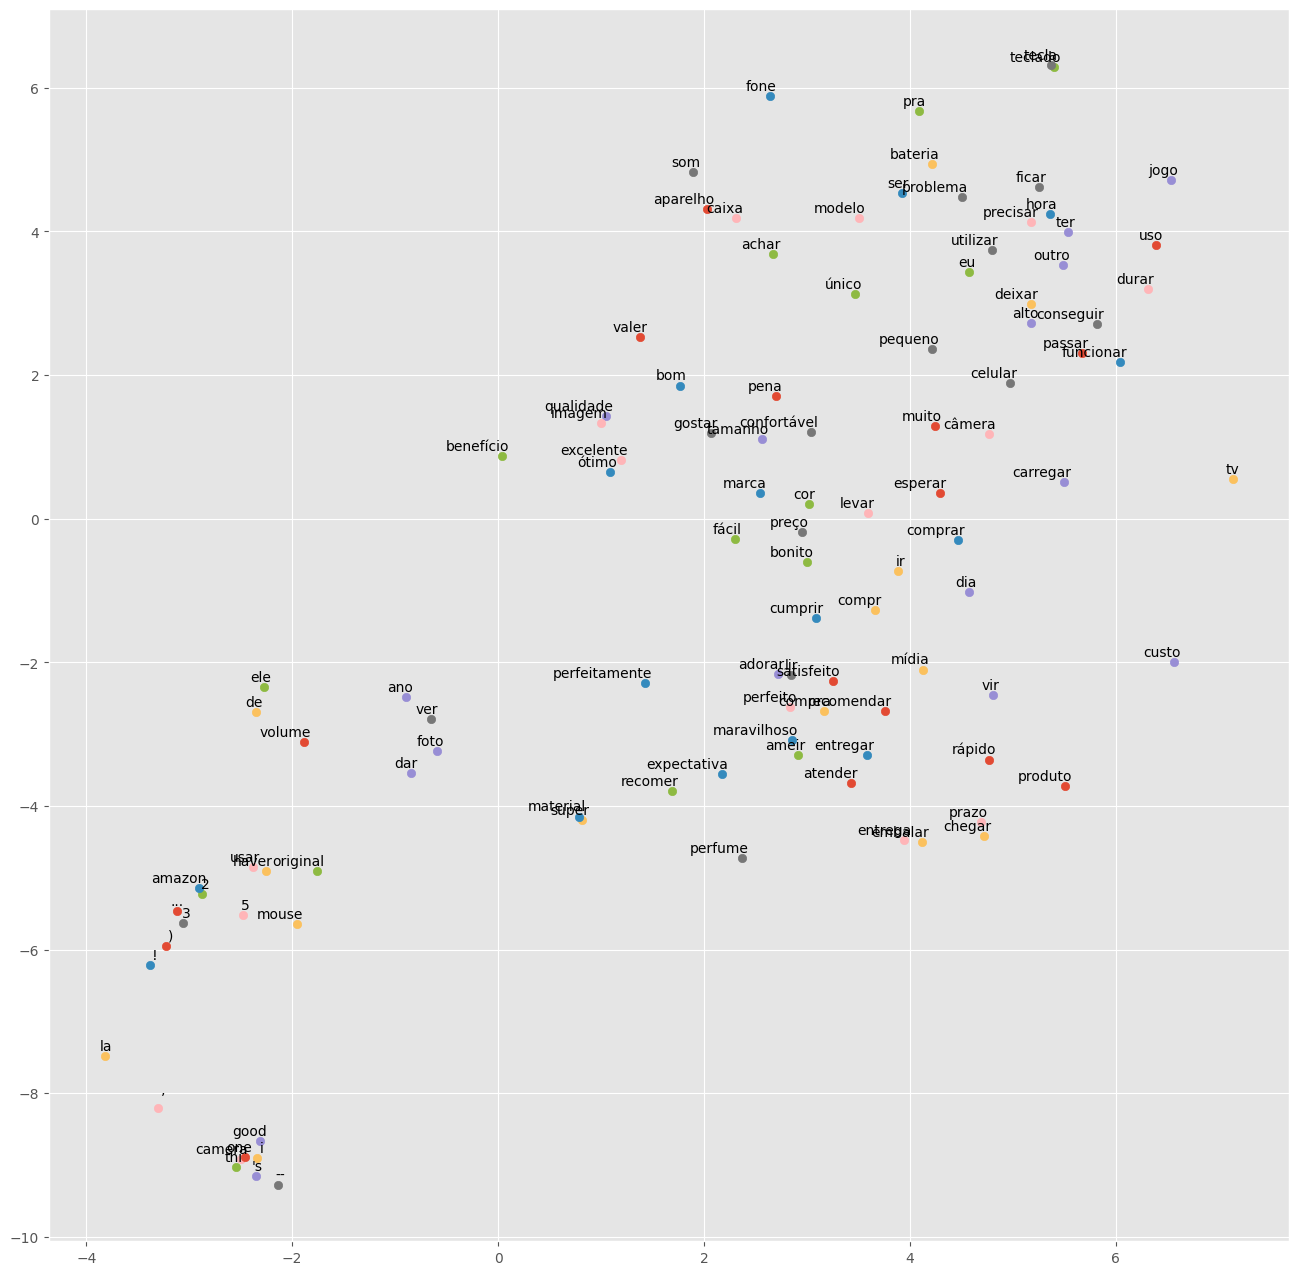

In [140]:
# Gerando um modelo de menor complexidade
model = Word2Vec(sentences,
                 vector_size=100,
                 window=10,
                 min_count=200,
                 workers=cores-1)

# Plotando o modelo
tsne_plot(model)

O gráfico permite a visualização de alguns agrupamentos interpretáveis, por exemplo bateria com problema, sugere problemas com bateria são relatados com certa frequência.

A palavra entregar agrupa com satisfeito, recomendar, perfeito, maravilhoso e amei, demonstrando a importância da entrega na avaliação positiva do comprador.

A palavra imagem se agrupa com qualidade, excelente e ótimo, demonstrando a importância que esse aspecto tem para consumidores.

É possível perdeber agrupamentos de palavras em inglês, como mencionado antes, apesar de gerarem um erro, seria difícil retirá-las da base de dados.

# 5.2 - Modelando tópicos a partir dos comentários para produtos específicos

In [141]:
# Construindo o algoritmo para formação de tópicos

# Função para converter texto em matriz
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.05, stop_words="english")

# Criando um algoritmo de LDA
n_topics=10
lda = LatentDirichletAllocation(n_components=n_topics,
                                max_iter=50,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

# Definindo uma função para retornar tópicos ocultos no texto
def print_topn_words(model, feature_names, topn):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-topn - 1:-1]])
        print(message)
    print()

In [142]:
# Rodando o modelo para smartphones
t0 = time.time()
smartphone_tfidf = tfidf_vectorizer.fit_transform(smartphone['clean_text_without_stopwords'])
smartphone_tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
lda.fit(smartphone_tfidf)
print_topn_words(lda, smartphone_tfidf_feature_names, 10)
print("Done in %0.3fs." % (time.time() - t0))

Topic #0: atender aparelho vir dia embalar chegar produto celular problema carregador
Topic #1: bateria carregar celular perfeito pra durar usar compr rápido dia
Topic #2: rápido excelente recomer trar recomendar chegar aparelho entrega câmera foto
Topic #3: produto custo super rápido chegar entrega entregar excelente bom qualidade
Topic #4: vir achar gostar tela pra rápido perfeito preço chegar dia
Topic #5: uso excelente xiaomi celular recomendar aparelho câmera trar dia ele
Topic #6: celular bom gostar funcionar produto preço compr pra aparelho vendedor
Topic #7: vir tela dia celular embalar gostar problema rápido câmera bom
Topic #8: chegar lir prazo excelente vendedor aparelho qualidade produto dia bateria
Topic #9: recomer qualidade aparelho gostar super carregar bom dia vendedor preço

Done in 10.839s.


Embora a análise não tenha retornado tópicos de maneira clara, podemos extrair informações a respeito das características mais comentadas por consumidores que revisam a compra de smartphones. Confirmando alguns aspectos já discutidos ao longo da análise:

A embalagem, a entrega e o custo são pontos importantes;

A bateria, o carregador, a câmera e a tela parecem ser os principais pontos avaliados nos celulares;

Os consumidores tem emitidos reviews positivas para aperelhos da Xiaomi.

In [143]:
# Rodando o modelo para perfumes
t0 = time.time()
perfume_tfidf = tfidf_vectorizer.fit_transform(perfume['clean_text_without_stopwords'])
perfume_tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
lda.fit(perfume_tfidf)
print_topn_words(lda, perfume_tfidf_feature_names, 10)
print("Done in %0.3fs." % (time.time() - t0))

Topic #0: comprar vir perfume preço original fixação prazo cheiro fragrância maravilhoso
Topic #1: fragrância recomendar produto dia preço excelente chegar fixação maravilhoso ótimo
Topic #2: ótimo custo fragrância fixação perfume dia maravilhoso produto gostar excelente
Topic #3: pra dia preço bom gostar cheiro comprar fragrância perfeito excelente
Topic #4: chegar produto prazo entregar dia original preço perfeito bom vir
Topic #5: perfume bom maravilhoso fixação preço chegar gostar original recomendar dia
Topic #6: pra dia gostar preço cheiro perfume original fixação fragrância vir
Topic #7: excelente fixação original produto perfume preço dia bom fragrância chegar
Topic #8: cheiro perfeito perfume original fixação produto comprar maravilhoso entregar custo
Topic #9: gostar produto cheiro original fragrância comprar fixação custo perfume pra

Done in 3.253s.


Para perfumes, podemos confirmar que:

O preço é um fator muito mencionado;

A embalagem e a entrega são pontos importantes;

As principais características comentadas desse produto são a fixação e a fragrância. O produto ser original também é um aspecto importante.

# **6 - Conclusões**

Os resultados demonstram o potencial de utilizar o processamento de linguagem natural para compreender a interação de compradores com os produtos. Dentre outras análises de interesse, essa técnica pode ser tuilizada por uma empresa para extrair informações de dados coletados por outra. Por exemplo, a Xiaomi poderia avaliar os comentários de seus produtos no site da Amazon, tendo acesso aos principais aspectos comentados por compradores a respeito de seus produtos, identificando pontos fortes e possibilidades de melhoria e comparando comentários de seus produtos com os da concorrência.

Quanto aos resultados da presente análise, apesar das dificuldades de avaliar um conjunto de dados de linguagem natural sem processamento prévio, foi possível observar alguns padrões. Os compradores em geral se mostram satisfeitos com suas compras na Amazon, independente do produto adquirido. As principais preocupações de vendedores em relação ao atendimento são promover uma entrega rápida e com uma embalagem adequada. A visão de qualidade dos compradores está diretamente ligada com a aparência e acabamento dos produtos.

Para produtos específicos é possível verificar as características que os compradores mais mencionam nas revisões, ou seja, as que lhe trazem maior preocupação. Por exemplo, para celulares, a bateria, a câmera, a tela são os principais pontos comentados.